In [ ]:
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
from datetime import datetime
import os
import cv2
import numpy as np

def Write_to_file(Date, net_worth, filename='{}.txt'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))):
    for i in net_worth: 
        Date += " {}".format(i)
    #print(Date)
    if not os.path.exists('logs'):
        os.makedirs('logs')
    file = open("logs/"+filename, 'a+')
    file.write(Date+"\n")
    file.close()

class TradingGraph:
    # A crypto trading visualization using matplotlib made to render custom prices which come in following way:
    # Date, Open, High, Low, Close, Volume, net_worth, trades
    # call render every step
    def __init__(self, Render_range, Show_reward=False, Show_indicators=False):
        self.Volume = deque(maxlen=Render_range)
        self.net_worth = deque(maxlen=Render_range)
        self.render_data = deque(maxlen=Render_range)
        self.Render_range = Render_range
        self.Show_reward = Show_reward
        self.Show_indicators = Show_indicators

        # We are using the style ‘ggplot’
        plt.style.use('ggplot')
        # close all plots if there are open
        plt.close('all')
        # figsize attribute allows us to specify the width and height of a figure in unit inches
        self.fig = plt.figure(figsize=(16,8)) 

        # Create top subplot for price axis
        self.ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1)
        
        # Create bottom subplot for volume which shares its x-axis
        self.ax2 = plt.subplot2grid((8,1), (5,0), rowspan=1, colspan=1, sharex=self.ax1)
        self.ax5 = plt.subplot2grid((8,1), (6,0), rowspan=1, colspan=1, sharex=self.ax1)
        self.ax6 = plt.subplot2grid((8,1), (7,0), rowspan=1, colspan=1, sharex=self.ax1)
        
        # Create a new axis for net worth which shares its x-axis with price
        self.ax3 = self.ax1.twinx()

        # Formatting Date
        self.date_format = mpl_dates.DateFormatter('%d-%m-%Y')
        
        # Add paddings to make graph easier to view
        #plt.subplots_adjust(left=0.07, bottom=-0.1, right=0.93, top=0.97, wspace=0, hspace=0)

        # define if show indicators
        if self.Show_indicators:
            self.Create_indicators_lists()

    def Create_indicators_lists(self):
        # Create a new axis for indicatorswhich shares its x-axis with volume
        self.ax4 = self.ax2.twinx()
        
        self.ema5 = deque(maxlen=self.Render_range)
        self.ema8 = deque(maxlen=self.Render_range)
        self.ema13 = deque(maxlen=self.Render_range)

        self.MACD = deque(maxlen=self.Render_range)
        self.MACD_signal = deque(maxlen=self.Render_range)
        self.MACD_hist = deque(maxlen=self.Render_range)
        
        self.RSI = deque(maxlen=self.Render_range)


    def Plot_indicators(self, df, Date_Render_range):
        self.ema5.append(df["ema5"])
        self.ema8.append(df["ema8"])
        self.ema13.append(df["ema13"])

        self.MACD.append(df["MACD"])
        self.MACD_signal.append(df["MACD signal"])
        self.MACD_hist.append(df["MACD hist"])
        self.RSI.append(df["RSI"])

        # Add Simple Moving Average
        #self.ax1.plot(Date_Render_range, self.ema5,'r-')
        #self.ax1.plot(Date_Render_range, self.ema8,'g-')
        #self.ax1.plot(Date_Render_range, self.ema13,'b-')

        self.ax4.clear()
        self.ax5.clear()
        self.ax6.clear()
        # # Add Moving Average Convergence Divergence
        self.ax5.plot(Date_Render_range, self.MACD,'r-')
        self.ax5.plot(Date_Render_range, self.MACD_signal,'b-')
        self.ax5.plot(Date_Render_range, self.MACD_hist,'g-')
        self.ax5.fill_between(Date_Render_range, 0, self.MACD_hist, where=(np.array(self.MACD_hist)-1) < -1 , color='red')
        self.ax5.fill_between(Date_Render_range, 0, self.MACD_hist, where=(np.array(self.MACD_hist)-1) > -1 , color='green')

        # # Add Relative Strength Index
        self.ax6.plot(Date_Render_range, self.RSI,'b-')

    # Render the environment to the screen
    #def render(self, Date, Open, High, Low, Close, Volume, net_worth, trades):
    def render(self, df, net_worth, trades):
        Date = df["time"]
        Open = df["open"]
        High = df["high"]
        Low = df["low"]
        Close = df["close"]
        Volume = df["tick_volume"]
        # append volume and net_worth to deque list
        self.Volume.append(Volume)
        self.net_worth.append(net_worth)

        # before appending to deque list, need to convert Date to special format
        Date = mpl_dates.date2num([pd.to_datetime(Date)])[0]
        self.render_data.append([Date, Open, High, Low, Close])
        
        # Clear the frame rendered last step
        self.ax1.clear()
        candlestick_ohlc(self.ax1, self.render_data, width=0.8/24, colorup='green', colordown='red', alpha=0.8)

        # Put all dates to one list and fill ax2 sublot with volume
        Date_Render_range = [i[0] for i in self.render_data]
        self.ax2.clear()
        self.ax2.fill_between(Date_Render_range, self.Volume, 0, color = 'gray')

        if self.Show_indicators:
            self.Plot_indicators(df, Date_Render_range)

        # draw our net_worth graph on ax3 (shared with ax1) subplot
        self.ax3.clear()
        self.ax3.plot(Date_Render_range, self.net_worth, color="black")
        
        # beautify the x-labels (Our Date format)
        self.ax1.xaxis.set_major_formatter(self.date_format)
        self.fig.autofmt_xdate()

        minimum = np.min(np.array(self.render_data)[:,1:])
        maximum = np.max(np.array(self.render_data)[:,1:])
        RANGE = maximum - minimum


        # sort sell and buy orders, put arrows in appropiate order positions
        for trade in trades:
            trade_date = mpl_dates.date2num([pd.to_datetime(trade['datetime'])])[0]
            if trade_date in Date_Render_range:
                if trade['type'] == 'buy':
                    high_low = trade['low'] - RANGE*0.02
                    ycoords = trade['low'] - RANGE*0.08
                    self.ax1.scatter(trade_date, high_low, c='green', label='green', s = 120, edgecolors='none', marker="^")
                else:
                    high_low = trade['high'] + RANGE*0.02
                    ycoords = trade['high'] + RANGE*0.06
                    self.ax1.scatter(trade_date, high_low, c='red', label='red', s = 120, edgecolors='none', marker="v")

                if self.Show_reward:
                    try:
                        self.ax1.annotate('{0:.2f}'.format(trade['Reward']), (trade_date-0.02, high_low), xytext=(trade_date-0.02, ycoords),
                                                   bbox=dict(boxstyle='round', fc='w', ec='k', lw=1), fontsize="small")
                    except:
                        pass

        # we need to set layers every step, because we are clearing subplots every step
        self.ax2.set_xlabel('Date')
        self.ax1.set_ylabel('Price')
        self.ax3.set_ylabel('Balance')

        # I use tight_layout to replace plt.subplots_adjust
        self.fig.tight_layout()

        """Display image with matplotlib - interrupting other tasks"""
        # Show the graph without blocking the rest of the program
        #plt.show(block=False)
        # Necessary to view frames before they are unrendered
        #plt.pause(0.001)

        """Display image with OpenCV - no interruption"""

        # redraw the canvas
        self.fig.canvas.draw()
        # convert canvas to image
        img = np.fromstring(self.fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img  = img.reshape(self.fig.canvas.get_width_height()[::-1] + (3,))
        
        # img is rgb, convert to opencv's default bgr
        image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # display image with OpenCV or any operation you like
        cv2.imshow("Bitcoin trading bot",image)

        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return
        else:
            return img
        

def Plot_OHCL(df):
    df_original = df.copy()
    # necessary convert to datetime
    df["datetime"] = pd.to_datetime(df.Date)
    df["datetime"] = df["date"].apply(mpl_dates.date2num)

    df = df[['date', 'open', 'high', 'low', 'close', 'volume']]
    
    # We are using the style ‘ggplot’
    plt.style.use('ggplot')
    
    # figsize attribute allows us to specify the width and height of a figure in unit inches
    fig = plt.figure(figsize=(16,8)) 

    # Create top subplot for price axis
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1)

    # Create bottom subplot for volume which shares its x-axis
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
    ax5 = plt.subplot2grid((8,1), (6,0), rowspan=1, colspan=1, sharex=ax1)
    ax6 = plt.subplot2grid((8,1), (7,0), rowspan=1, colspan=1, sharex=ax1)

    candlestick_ohlc(ax1, df.values, width=0.8/24, colorup='green', colordown='red', alpha=0.8)
    ax1.set_ylabel('Price', fontsize=12)
    plt.xlabel('Date')
    plt.xticks(rotation=45)

    # Add Simple Moving Average
    ax1.plot(df["Date"], df_original['ema5'],'-')
    ax1.plot(df["Date"], df_original['ema8'],'-')
    ax1.plot(df["Date"], df_original['ema13'],'-')

    # # Add Moving Average Convergence Divergence
    ax5.plot(df["Date"], df_original['MACD'],'-')
    ax5.plot(df["Date"], df_original['MACD signal'],'-')
    ax5.fill_between(df["Date"], 0,df_original['MACD'], where=(df_original['MACD']-1) < -1 , color='red')
    ax5.fill_between(df["Date"], 0,df_original['MACD'], where=(df_original['MACD']-1) > -1 , color='green')

    # # Add Relative Strength Index
    ax6.plot(df["Date"], df_original['RSI'],'-')

    # beautify the x-labels (Our Date format)
    ax1.xaxis.set_major_formatter(mpl_dates.DateFormatter('%y-%m-%d'))# %H:%M:%S'))
    fig.autofmt_xdate()
    fig.tight_layout()
    
    plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import backend as K
#tf.config.experimental_run_functions_eagerly(True) # used for debuging and development
tf.compat.v1.disable_eager_execution() # usually using this for fastest performance

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f'GPUs {gpus}')
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError: pass

class Shared_Model:
    def __init__(self, input_shape, action_space, lr, optimizer, model="Dense"):
        X_input = Input(input_shape)
        self.action_space = action_space

        # Shared CNN layers:
        if model=="CNN":
            X = Conv1D(filters=64, kernel_size=6, padding="same", activation="tanh")(X_input)
            X = MaxPooling1D(pool_size=2)(X)
            X = Conv1D(filters=32, kernel_size=3, padding="same", activation="tanh")(X)
            X = MaxPooling1D(pool_size=2)(X)
            X = Flatten()(X)

        # Shared LSTM layers:
        elif model=="LSTM":
            X = LSTM(512, return_sequences=True)(X_input)
            X = LSTM(256)(X)

        # Shared Dense layers:
        else:
            X = Flatten()(X_input)
            X = Dense(512, activation="relu")(X)
        
        # Critic model
        V = Dense(512, activation="relu")(X)
        V = Dense(256, activation="relu")(V)
        V = Dense(64, activation="relu")(V)
        value = Dense(1, activation=None)(V)

        self.Critic = Model(inputs=X_input, outputs = value)
        self.Critic.compile(loss=self.critic_PPO2_loss, optimizer=optimizer(lr=lr))

        # Actor model
        A = Dense(512, activation="relu")(X)
        A = Dense(256, activation="relu")(A)
        A = Dense(64, activation="relu")(A)
        output = Dense(self.action_space, activation="softmax")(A)

        self.Actor = Model(inputs = X_input, outputs = output)
        self.Actor.compile(loss=self.ppo_loss, optimizer=optimizer(lr=lr))
        print(self.Actor.summary())

    def ppo_loss(self, y_true, y_pred):
        # Defined in https://arxiv.org/abs/1707.06347
        advantages, prediction_picks, actions = y_true[:, :1], y_true[:, 1:1+self.action_space], y_true[:, 1+self.action_space:]
        LOSS_CLIPPING = 0.2
        ENTROPY_LOSS = 0.001
        
        prob = actions * y_pred
        old_prob = actions * prediction_picks

        prob = K.clip(prob, 1e-10, 1.0)
        old_prob = K.clip(old_prob, 1e-10, 1.0)

        ratio = K.exp(K.log(prob) - K.log(old_prob))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages

        actor_loss = -K.mean(K.minimum(p1, p2))

        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy

        return total_loss

    def actor_predict(self, state):
        return self.Actor.predict(state)

    def critic_PPO2_loss(self, y_true, y_pred):
        value_loss = K.mean((y_true - y_pred) ** 2) # standard PPO loss
        return value_loss

    def critic_predict(self, state):
        return self.Critic.predict([state, np.zeros((state.shape[0], 1))])

        
class Actor_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        self.action_space = action_space

        X = Flatten(input_shape=input_shape)(X_input)
        X = Dense(512, activation="relu")(X)
        X = Dense(256, activation="relu")(X)
        X = Dense(64, activation="relu")(X)
        output = Dense(self.action_space, activation="softmax")(X)

        self.Actor = Model(inputs = X_input, outputs = output)
        self.Actor.compile(loss=self.ppo_loss, optimizer=optimizer(lr=lr))
        #print(self.Actor.summary)

    def ppo_loss(self, y_true, y_pred):
        # Defined in https://arxiv.org/abs/1707.06347
        advantages, prediction_picks, actions = y_true[:, :1], y_true[:, 1:1+self.action_space], y_true[:, 1+self.action_space:]
        LOSS_CLIPPING = 0.2
        ENTROPY_LOSS = 0.001
        
        prob = actions * y_pred
        old_prob = actions * prediction_picks

        prob = K.clip(prob, 1e-10, 1.0)
        old_prob = K.clip(old_prob, 1e-10, 1.0)

        ratio = K.exp(K.log(prob) - K.log(old_prob))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages

        actor_loss = -K.mean(K.minimum(p1, p2))

        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy

        return total_loss

    def actor_predict(self, state):
        return self.Actor.predict(state)

class Critic_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)

        V = Flatten(input_shape=input_shape)(X_input)
        V = Dense(512, activation="relu")(V)
        V = Dense(256, activation="relu")(V)
        V = Dense(64, activation="relu")(V)
        value = Dense(1, activation=None)(V)

        self.Critic = Model(inputs=X_input, outputs = value)
        self.Critic.compile(loss=self.critic_PPO2_loss, optimizer=optimizer(lr=lr))

    def critic_PPO2_loss(self, y_true, y_pred):
        value_loss = K.mean((y_true - y_pred) ** 2) # standard PPO loss
        return value_loss

    def critic_predict(self, state):
        return self.Critic.predict([state, np.zeros((state.shape[0], 1))])


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import copy
import pandas as pd
import numpy as np
import random
from collections import deque
from tensorboardX import SummaryWriter
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
from datetime import datetime
import MetaTrader5 as mt5
import time

class CustomAgent:
    # A custom Bitcoin trading agent
    def __init__(self, lookback_window_size=50, lr=0.00005, epochs=1, optimizer=Adam, batch_size=32, model=""):
        self.lookback_window_size = lookback_window_size
        self.model = model
        
        # Action space from 0 to 3, 0 is hold, 1 is buy, 2 is sell
        self.action_space = np.array([0, 1, 2])

        # folder to save models
        self.log_name = datetime.now().strftime("%Y_%m_%d_%H_%M")+"_trader"
        
        # State size contains Market+Orders history for the last lookback_window_size steps
        self.state_size = (lookback_window_size, 10+0)

        # Neural Networks part bellow
        self.lr = lr
        self.epochs = epochs
        self.optimizer = optimizer
        self.batch_size = batch_size

        # Create shared Actor-Critic network model
        self.Actor = self.Critic = Shared_Model(input_shape=self.state_size, action_space = self.action_space.shape[0], lr=self.lr, optimizer = self.optimizer, model=self.model)
        # Create Actor-Critic network model
        #self.Actor = Actor_Model(input_shape=self.state_size, action_space = self.action_space.shape[0], lr=self.lr, optimizer = self.optimizer)
        #self.Critic = Critic_Model(input_shape=self.state_size, action_space = self.action_space.shape[0], lr=self.lr, optimizer = self.optimizer)
        
    # create tensorboard writer
    def create_writer(self, initial_balance, normalize_value, train_episodes):
        self.replay_count = 0
        self.writer = SummaryWriter('runs/'+self.log_name)

        # Create folder to save models
        if not os.path.exists(self.log_name):
            os.makedirs(self.log_name)

        self.start_training_log(initial_balance, normalize_value, train_episodes)
            
    def start_training_log(self, initial_balance, normalize_value, train_episodes):      
        # save training parameters to Parameters.txt file for future
        with open(self.log_name+"/Parameters.txt", "w") as params:
            current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
            params.write(f"training start: {current_date}\n")
            params.write(f"initial_balance: {initial_balance}\n")
            params.write(f"training episodes: {train_episodes}\n")
            params.write(f"lookback_window_size: {self.lookback_window_size}\n")
            params.write(f"lr: {self.lr}\n")
            params.write(f"epochs: {self.epochs}\n")
            params.write(f"batch size: {self.batch_size}\n")
            params.write(f"normalize_value: {normalize_value}\n")
            params.write(f"model: {self.model}\n")
            
    def end_training_log(self):
        with open(self.log_name+"/Parameters.txt", "a+") as params:
            current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
            params.write(f"training end: {current_date}\n")

    def get_gaes(self, rewards, dones, values, next_values, gamma = 0.99, lamda = 0.95, normalize=True):
        deltas = [r + gamma * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(deltas) - 1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * gamma * lamda * gaes[t + 1]

        target = gaes + values
        if normalize:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)

    def replay(self, states, actions, rewards, predictions, dones, next_states):
        # reshape memory to appropriate shape for training
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        predictions = np.vstack(predictions)

        # Get Critic network predictions 
        values = self.Critic.critic_predict(states)
        next_values = self.Critic.critic_predict(next_states)
        
        # Compute advantages
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))
        '''
        plt.plot(target,'-')
        plt.plot(advantages,'.')
        ax=plt.gca()
        ax.grid(True)
        plt.show()
        '''
        # stack everything to numpy array
        y_true = np.hstack([advantages, predictions, actions])
        
        # training Actor and Critic networks
        a_loss = self.Actor.Actor.fit(states, y_true, epochs=self.epochs, verbose=0, shuffle=True, batch_size=self.batch_size)
        c_loss = self.Critic.Critic.fit(states, target, epochs=self.epochs, verbose=0, shuffle=True, batch_size=self.batch_size)

        self.writer.add_scalar('Data/actor_loss_per_replay', np.sum(a_loss.history['loss']), self.replay_count)
        self.writer.add_scalar('Data/critic_loss_per_replay', np.sum(c_loss.history['loss']), self.replay_count)
        self.replay_count += 1

        return np.sum(a_loss.history['loss']), np.sum(c_loss.history['loss'])

    def act(self, state):
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.actor_predict(np.expand_dims(state, axis=0))[0]
        action = np.random.choice(self.action_space, p=prediction)
        return action, prediction
        
    def save(self, name="trader", score="", args=[]):
        # save keras model weights
        self.Actor.Actor.save_weights(f"{self.log_name}/{score}_{name}_Actor.h5")
        self.Critic.Critic.save_weights(f"{self.log_name}/{score}_{name}_Critic.h5")

        # log saved model arguments to file
        if len(args) > 0:
            with open(f"{self.log_name}/log.txt", "a+") as log:
                current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                log.write(f"{current_time}, {args[0]}, {args[1]}, {args[2]}, {args[3]}, {args[4]}\n")

    def load(self, folder, name):
        # load keras model weights
        self.Actor.Actor.load_weights(os.path.join(folder, f"{name}_Actor.h5"))
        self.Critic.Critic.load_weights(os.path.join(folder, f"{name}_Critic.h5"))

        
class CustomTradingEnv:
    # A custom Bitcoin trading environment
    def __init__(self, symbol = 'CNYRUBrfd_0_1s', lookback_window_size=50, Render_range=100, Show_reward=False, normalize_value=40000):
        # Define action space and state size and other custom parameters
        self.df = pd.DataFrame(mt5.copy_rates_from(symbol, mt5.TIMEFRAME_M1, datetime.now(), lookback_window_size))
        self.df_total_steps = len(self.df)-1
        self.initial_balance = mt5.account_info()._asdict()['balance']
        self.lookback_window_size = lookback_window_size
        self.Render_range = Render_range # render range in visualization
        self.Show_reward = Show_reward # show order reward in rendered visualization
        self.symbol = symbol

        # Orders history contains the balance, net_worth, crypto_bought, crypto_sold, crypto_held values for the last lookback_window_size steps
        self.orders_history = deque(maxlen=self.lookback_window_size)
        
        # Market history contains the OHCL values for the last lookback_window_size prices
        self.market_history = deque(maxlen=self.lookback_window_size)

        self.normalize_value = normalize_value

    # Reset the state of the environment to an initial state
    def reset(self, env_steps_size = 0):
        self.visualization = TradingGraph(Render_range=self.Render_range, Show_reward=self.Show_reward) # init visualization
        self.trades = deque(maxlen=self.Render_range) # limited orders memory for visualization
        
        self.balance = mt5.account_info()._asdict()['balance']
        self.net_worth = mt5.account_info()._asdict()['balance']
        self.prev_net_worth = mt5.account_info()._asdict()['balance']
        self.held = 0
        self.sold = 0
        self.bought = 0
        self.episode_orders = 0 # track episode orders count
        self.prev_episode_orders = 0 # track previous episode orders count
        self.rewards = deque(maxlen=self.Render_range)
        self.env_steps_size = env_steps_size
        self.punish_value = 0
        if env_steps_size > 0: # used for training dataset
            self.start_step = random.randint(self.lookback_window_size, self.df_total_steps - env_steps_size)
            self.end_step = self.start_step + env_steps_size
        else: # used for testing dataset
            self.start_step = self.lookback_window_size-1
            self.end_step = self.df_total_steps
            
        self.current_step = self.start_step

        for i in reversed(range(self.lookback_window_size)):
            current_step = self.current_step - i
            self.orders_history.append([self.balance, self.net_worth, self.bought, self.sold, self.held])
            self.market_history.append([self.df.loc[current_step, 'open'],
                                        self.df.loc[current_step, 'high'],
                                        self.df.loc[current_step, 'low'],
                                        self.df.loc[current_step, 'close'],
                                        self.df.loc[current_step, 'tick_volume'],
                                        self.df.loc[current_step, 'spread'],
                                        ])

        state = np.concatenate((self.market_history, self.orders_history), axis=1)
        return state

    def _next_observation(self):
        self.market_history.append([self.df.loc[self.current_step, 'open'],
                                    self.df.loc[self.current_step, 'high'],
                                    self.df.loc[self.current_step, 'low'],
                                    self.df.loc[self.current_step, 'close'],
                                    self.df.loc[self.current_step, 'tick_volume'],
                                    self.df.loc[self.current_step, 'spread'],
                                    ])
        
        
        obs = np.concatenate((self.market_history, self.orders_history), axis=1)
        
        return obs
    
    # Get the data points for the given current_step
    def _next_trading_observation(self):
        current_time = self.df.loc[self.current_step-1, 'time']

        while current_time == mt5.copy_rates_from(self.symbol, mt5.TIMEFRAME_M1, datetime.now(), 1)[0][0]:
            time.sleep(0.1)
        new_observation = pd.DataFrame(mt5.copy_rates_from(self.symbol, mt5.TIMEFRAME_M1, datetime.now(), 1))
        self.df = pd.concat(self.df, new_observation)

        self.market_history.append([self.df.loc[self.current_step, 'open'],
                                    self.df.loc[self.current_step, 'high'],
                                    self.df.loc[self.current_step, 'low'],
                                    self.df.loc[self.current_step, 'close'],
                                    self.df.loc[self.current_step, 'tick_volume'],
                                    self.df.loc[self.current_step, 'spread'],
                                    ])
        
        obs = np.concatenate((self.market_history, self.orders_history), axis=1)
        return obs

    # Execute one time step within the environment
    def step(self, action):
        self.bought = 0
        self.sold = 0
        self.current_step += 1

        # Set the current price to a random price between open and close
        #current_price = random.uniform(
        #    self.df.loc[self.current_step, 'Open'],
        #    self.df.loc[self.current_step, 'Close'])
        current_price_sell = self.df.loc[self.current_step, 'open']
        current_price_buy = self.df.loc[self.current_step, 'open']+(self.df.loc[self.current_step, 'spread']*0.0002)
        Date = self.df.loc[self.current_step, 'time'] # for visualization
        High = self.df.loc[self.current_step, 'high'] # for visualization
        Low = self.df.loc[self.current_step, 'low']
        lot = 0.1 # for visualization


        if action == 0: # Hold
            pass

        elif action == 1 and self.balance > self.initial_balance/100:
            # Buy with 100% of current balance
            self.bought += lot
            self.balance -= 100000*lot*current_price_buy
            self.held += self.bought
            self.trades.append({'Date' : Date, 'High' : High, 'Low' : Low, 'total': self.bought, 'type': "buy", 'current_price_buy': current_price_buy, 'current_price_sell': current_price_sell})
            self.episode_orders += 1

        elif action == 2 and self.held>0:
            # Sell 100% of current crypto held
            self.sold = self.held
            self.balance += self.sold * current_price_sell
            self.held -= self.sold
            self.trades.append({'Date' : Date, 'High' : High, 'Low' : Low, 'total': self.sold, 'type': "sell", 'current_price_buy': current_price_buy, 'current_price_sell': current_price_sell})
            self.episode_orders += 1

        self.prev_net_worth = self.net_worth
        self.net_worth = self.balance + self.held * current_price_sell

        self.orders_history.append([self.balance, self.net_worth, self.bought, self.sold, self.held])

        # Receive calculated reward
        reward = self.get_reward()

        if self.net_worth <= self.initial_balance/2:
            done = True
        else:
            done = False

        obs = self._next_observation() / self.normalize_value
        
        return obs, reward, done
    
    def step_trade(self, action):
        self.bought = 0
        self.sold = 0
        self.current_step += 1

        # Set the current price to a random price between open and close
        #current_price = random.uniform(
        #    self.df.loc[self.current_step, 'Open'],
        #    self.df.loc[self.current_step, 'Close'])
        current_price_sell = mt5.symbol_info_tick(symbol).bid
        current_price_buy = mt5.symbol_info_tick(symbol).ask
        Date = self.df.loc[self.current_step, 'time'] # for visualization
        High = self.df.loc[self.current_step, 'high'] # for visualization
        Low = self.df.loc[self.current_step, 'low'] # for visualization
        deviation = 20
        lot = 0.1
        if action == 0: # Hold
            pass

        elif action == 1 and self.balance > self.initial_balance/100:
            # Buy
            request = {
                "action": mt5.TRADE_ACTION_DEAL,
                "symbol": self.symbol,
                "volume": lot,
                "type": mt5.ORDER_TYPE_BUY,
                "price": current_price_buy,
                "deviation": deviation,
                "magic": 234000,
                "comment": "python script open",
                "type_time": mt5.ORDER_TIME_GTC,
                "type_filling": mt5.ORDER_FILLING_FOK,
            }
            result = mt5.order_send(request)

            print("1. order_send(): by {} {} lots at {} with deviation={} points".format(self.symbol,lot,current_price_buy,deviation));
            if result.retcode != mt5.TRADE_RETCODE_DONE:
                print("2. order_send failed, retcode={}".format(result.retcode))
                # request the result as a dictionary and display it element by element
                result_dict=result._asdict()
                for field in result_dict.keys():
                    print("   {}={}".format(field,result_dict[field]))
                    # if this is a trading request structure, display it element by element as well
                    if field=="request":
                        traderequest_dict=result_dict[field]._asdict()
                        for tradereq_filed in traderequest_dict:
                            print("       traderequest: {}={}".format(tradereq_filed,traderequest_dict[tradereq_filed]))
                print("shutdown() and quit")
                mt5.shutdown()
                quit()
            
            print("2. order_send done, ", result)
            print("   opened position with POSITION_TICKET={}".format(result.order))
            print("======================================================================================================")
            print("")
            self.position_id=result.order
            self.bought += 0.1
            self.balance = mt5.account_info()._asdict()['balance']
            self.held += self.bought
            self.trades.append({'date' : Date, 'high' : High, 'low' : Low, 'total': self.bought, 'type': "buy", 'current_price_buy': current_price_buy, 'current_price_sell': current_price_sell })
            self.episode_orders += 1

        elif action == 2 and self.held>0:
            # Sell
            self.sold = self.held
            lot = self.sold
            deviation=20
            request={
                "action": mt5.TRADE_ACTION_DEAL,
                "symbol": self.symbol,
                "volume": lot,
                "type": mt5.ORDER_TYPE_SELL,
                "position": self.position_id,
                "price": current_price_sell,
                "deviation": deviation,
                "magic": 234000,
                "comment": "python script close",
                "type_time": mt5.ORDER_TIME_GTC,
                "type_filling": mt5.ORDER_FILLING_FOK,
            }
            result=mt5.order_send(request)

            print("1. close position #{}: sell {} {} lots at {} with deviation={} points".format(position_id,symbol,lot,price,deviation))
            if result.retcode != mt5.TRADE_RETCODE_DONE:
                print("2. order_send failed, retcode={}".format(result.retcode))
                print("   result",result)
            else:
                print("2. position #{} closed, {}".format(position_id,result))
                # request the result as a dictionary and display it element by element
                result_dict=result._asdict()
                for field in result_dict.keys():
                    print("   {}={}".format(field,result_dict[field]))
                    # if this is a trading request structure, display it element by element as well
                    if field=="request":
                        traderequest_dict=result_dict[field]._asdict()
                        for tradereq_filed in traderequest_dict:
                            print("       traderequest: {}={}".format(tradereq_filed,traderequest_dict[tradereq_filed]))
            print("======================================================================================================")
            print("")
            self.balance = mt5.account_info()._asdict()['balance']
            self.held -= self.sold
            self.trades.append({'Date' : Date, 'High' : High, 'Low' : Low, 'total': self.sold, 'type': "sell", 'current_price_buy': current_price_buy, 'current_price_sell': current_price_sell})
            self.episode_orders += 1

        self.prev_net_worth = self.net_worth
        self.net_worth = self.balance + self.held * current_price_sell

        self.orders_history.append([self.balance, self.net_worth, self.bought, self.sold, self.held])

        # Receive calculated reward
        reward = self.get_reward()

        if self.net_worth <= self.initial_balance/2:
            done = True
        else:
            done = False

        obs = self._next_trading_observation() / self.normalize_value
        
        return obs, reward, done

    # Calculate reward
    def get_reward(self):
        self.punish_value += self.net_worth * 0.00001
        if self.episode_orders > 1 and self.episode_orders > self.prev_episode_orders:
            self.prev_episode_orders = self.episode_orders
            if self.trades[-1]['type'] == "buy" and self.trades[-2]['type'] == "sell":
                reward = self.trades[-2]['total']*self.trades[-2]['current_price_sell'] - self.trades[-2]['total']*self.trades[-1]['current_price_buy']
                reward -= self.punish_value
                self.punish_value = 0
                self.trades[-1]["Reward"] = reward
                return reward
            elif self.trades[-1]['type'] == "sell" and self.trades[-2]['type'] == "buy":
                reward = self.trades[-1]['total']*self.trades[-1]['current_price_buy'] - self.trades[-2]['total']*self.trades[-2]['current_price_sell']
                reward -= self.punish_value
                self.punish_value = 0
                self.trades[-1]["Reward"] = reward
                return reward
        else:
            return 0 - self.punish_value
        
    def get_reward(self):


    # render environment
    def render(self, visualize = False):
        #print(f'Step: {self.current_step}, Net Worth: {self.net_worth}')
        if visualize:
            Date = self.df.loc[self.current_step, 'Date']
            Open = self.df.loc[self.current_step, 'Open']
            Close = self.df.loc[self.current_step, 'Close']
            High = self.df.loc[self.current_step, 'High']
            Low = self.df.loc[self.current_step, 'Low']
            Volume = self.df.loc[self.current_step, 'Volume']
            # Render the environment to the screen
            self.visualization.render(Date, Open, High, Low, Close, Volume, self.net_worth, self.trades)

        
def Random_games(env, visualize, test_episodes = 50, comment=""):
    average_net_worth = 0
    average_orders = 0
    no_profit_episodes = 0
    for episode in range(test_episodes):
        state = env.reset()
        while True:
            env.render(visualize)
            action = np.random.randint(3, size=1)[0]
            state, reward, done = env.step(action)
            if env.current_step == env.end_step:
                average_net_worth += env.net_worth
                average_orders += env.episode_orders
                if env.net_worth < env.initial_balance: no_profit_episodes += 1 # calculate episode count where we had negative profit through episode
                print("episode: {}, net_worth: {}, average_net_worth: {}, orders: {}".format(episode, env.net_worth, average_net_worth/(episode+1), env.episode_orders))
                break

    print("average {} episodes random net_worth: {}, orders: {}".format(test_episodes, average_net_worth/test_episodes, average_orders/test_episodes))
    # save test results to test_results.txt file
    with open("test_results.txt", "a+") as results:
        current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
        results.write(f'{current_date}, {"Random games"}, test episodes:{test_episodes}')
        results.write(f', net worth:{average_net_worth/(episode+1)}, orders per episode:{average_orders/test_episodes}')
        results.write(f', no profit episodes:{no_profit_episodes}, comment: {comment}\n')

def train_agent(env, agent, visualize=False, train_episodes = 50, training_batch_size=500):
    agent.create_writer(env.initial_balance, env.normalize_value, train_episodes) # create TensorBoard writer
    total_average = deque(maxlen=100) # save recent 100 episodes net worth
    best_average = 0 # used to track best average net worth
    for episode in range(train_episodes):
        state = env.reset(env_steps_size = training_batch_size)

        states, actions, rewards, predictions, dones, next_states = [], [], [], [], [], []
        for t in range(training_batch_size):
            env.render(visualize)
            action, prediction = agent.act(state)
            next_state, reward, done = env.step(action)
            states.append(np.expand_dims(state, axis=0))
            next_states.append(np.expand_dims(next_state, axis=0))
            action_onehot = np.zeros(3)
            action_onehot[action] = 1
            actions.append(action_onehot)
            rewards.append(reward)
            dones.append(done)
            predictions.append(prediction)
            state = next_state

        a_loss, c_loss = agent.replay(states, actions, rewards, predictions, dones, next_states)
        total_average.append(env.net_worth)
        average = np.average(total_average)
        
        agent.writer.add_scalar('Data/average net_worth', average, episode)
        agent.writer.add_scalar('Data/episode_orders', env.episode_orders, episode)
        
        print("episode: {:<5} net worth {:<7.2f} average: {:<7.2f} orders: {}".format(episode, env.net_worth, average, env.episode_orders))
        if episode > len(total_average):
            if best_average < average:
                best_average = average
                print("Saving model")
                agent.save(score="{:.2f}".format(best_average), args=[episode, average, env.episode_orders, a_loss, c_loss])
            agent.save()
            
    agent.end_training_log()

def test_agent(env, agent, visualize=False, test_episodes=10, folder="", name="trader", comment=""):
    agent.load(folder, name)
    average_net_worth = 0
    average_orders = 0
    no_profit_episodes = 0
    for episode in range(test_episodes):
        state = env.reset()
        while True:
            env.render(visualize)
            action, prediction = agent.act(state)
            state, reward, done = env.step(action)
            if env.current_step == env.end_step:
                average_net_worth += env.net_worth
                average_orders += env.episode_orders
                if env.net_worth < env.initial_balance: no_profit_episodes += 1 # calculate episode count where we had negative profit through episode
                print("episode: {:<5}, net_worth: {:<7.2f}, average_net_worth: {:<7.2f}, orders: {}".format(episode, env.net_worth, average_net_worth/(episode+1), env.episode_orders))
                break

    print("average {} episodes agent net_worth: {}, orders: {}".format(test_episodes, average_net_worth/test_episodes, average_orders/test_episodes))
    print("No profit episodes: {}".format(no_profit_episodes))
    # save test results to test_results.txt file
    with open("test_results.txt", "a+") as results:
        current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
        results.write(f'{current_date}, {name}, test episodes:{test_episodes}')
        results.write(f', net worth:{average_net_worth/(episode+1)}, orders per episode:{average_orders/test_episodes}')
        results.write(f', no profit episodes:{no_profit_episodes}, model: {agent.model}, comment: {comment}\n')

def continue_train_agent(env, agent, visualize=False, train_episodes = 50, training_batch_size=500, folder="", name="trader"):
    agent.load(folder, name) # load TensorBoard writer
    total_average = deque(maxlen=100) # save recent 100 episodes net worth
    best_average = 0 # used to track best average net worth
    for episode in range(train_episodes):
        state = env.reset(env_steps_size = training_batch_size)

        states, actions, rewards, predictions, dones, next_states = [], [], [], [], [], []
        for t in range(training_batch_size):
            env.render(visualize)
            action, prediction = agent.act(state)
            next_state, reward, done = env.step(action)
            states.append(np.expand_dims(state, axis=0))
            next_states.append(np.expand_dims(next_state, axis=0))
            action_onehot = np.zeros(3)
            action_onehot[action] = 1
            actions.append(action_onehot)
            rewards.append(reward)
            dones.append(done)
            predictions.append(prediction)
            state = next_state

        a_loss, c_loss = agent.replay(states, actions, rewards, predictions, dones, next_states)
        total_average.append(env.net_worth)
        average = np.average(total_average)
        
        agent.writer.add_scalar('Data/average net_worth', average, episode)
        agent.writer.add_scalar('Data/episode_orders', env.episode_orders, episode)
        
        print("episode: {:<5} net worth {:<7.2f} average: {:<7.2f} orders: {}".format(episode, env.net_worth, average, env.episode_orders))
        if episode > len(total_average):
            if best_average < average:
                best_average = average
                print("Saving model")
                agent.save(score="{:.2f}".format(best_average), args=[episode, average, env.episode_orders, a_loss, c_loss])
            agent.save()
            
    agent.end_training_log()


def trade_agent(env, agent, visualize=False, test_episodes=10, folder="", name="trader", comment=""):
    agent.load(folder, name)
    average_net_worth = 0
    average_orders = 0
    no_profit_episodes = 0
    for episode in range(test_episodes):
        state = env.reset()
        while True:
            env.render(visualize)
            action, prediction = agent.act(state)
            state, reward, done = env.step_trade(action)
            if env.current_step == env.end_step:
                average_net_worth += env.net_worth
                average_orders += env.episode_orders
                if env.net_worth < env.initial_balance: no_profit_episodes += 1 # calculate episode count where we had negative profit through episode
                print("episode: {:<5}, net_worth: {:<7.2f}, average_net_worth: {:<7.2f}, orders: {}".format(episode, env.net_worth, average_net_worth/(episode+1), env.episode_orders))
                break

    print("average {} episodes agent net_worth: {}, orders: {}".format(test_episodes, average_net_worth/test_episodes, average_orders/test_episodes))
    print("No profit episodes: {}".format(no_profit_episodes))
    # save test results to test_results.txt file
    with open("test_results.txt", "a+") as results:
        current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
        results.write(f'{current_date}, {name}, test episodes:{test_episodes}')
        results.write(f', net worth:{average_net_worth/(episode+1)}, orders per episode:{average_orders/test_episodes}')
        results.write(f', no profit episodes:{no_profit_episodes}, model: {agent.model}, comment: {comment}\n')


    


In [6]:
import time
def learning (start):
    while True:
        print (f'Step {start}')
        start += 1
        time.sleep(5.6)

In [1]:
pip install ruptures

   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   - -------------------------------------- 1.8/46.2 MB 8.4 MB/s eta 0:00:06
   --- ------------------------------------ 4.2/46.2 MB 10.1 MB/s eta 0:00:05
   ----- ---------------------------------- 6.6/46.2 MB 10.6 MB/s eta 0:00:04
   ------- -------------------------------- 8.9/46.2 MB 10.9 MB/s eta 0:00:04
   --------- ------------------------------ 11.3/46.2 MB 11.0 MB/s eta 0:00:04
   ------------ --------------------------- 13.9/46.2 MB 11.2 MB/s eta 0:00:03
   -------------- ------------------------- 16.3/46.2 MB 11.2 MB/s eta 0:00:03
   ---------------- ----------------------- 18.6/46.2 MB 11.3 MB/s eta 0:00:03
   ------------------ --------------------- 21.2/46.2 MB 11.4 MB/s eta 0:00:03
   -------------------- ------------------- 23.9/46.2 MB 11.4 MB/s eta 0:00:02
   ---------------------- ----------------- 26.2/46.2 MB 11.5 MB/s eta 0:00:02
   ------------------------ --------------- 28.6/46.2 MB 11.5 MB/s

In [1]:
import pandas as pd
import MetaTrader5 as mt5

In [19]:
account_info=mt5.account_info()

In [20]:
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
 

    account_info=mt5.account_info()
    if account_info!=None:
        # display trading account data 'as is'
        print(account_info)
        # display trading account data in the form of a dictionary
        print("Show account_info()._asdict():")
        account_info_dict = mt5.account_info()._asdict()
        for prop in account_info_dict:
            print("  {}={}".format(prop, account_info_dict[prop]))
        print()
 
        # convert the dictionary into DataFrame and print
        df=pd.DataFrame(list(account_info_dict.items()),columns=['property','value'])
        print("account_info() as dataframe:")
        print(df)
else:
    print("failed to connect to trade account 25115284 with password=gqz0343lbdm, error code =",mt5.last_error())

failed to connect to trade account 25115284 with password=gqz0343lbdm, error code = (1, 'Success')


In [15]:
account_info=mt5.account_info()._asdict()

AttributeError: 'NoneType' object has no attribute '_asdict'

In [16]:
account_info['balance']

NameError: name 'account_info' is not defined

In [17]:
mt5.account_info()._asdict()['balance']

AttributeError: 'NoneType' object has no attribute '_asdict'

In [12]:
from datetime import datetime
import pandas as pd

In [21]:
df = pd.DataFrame(mt5.copy_rates_from('CNYRUBrfd_0_1s', mt5.TIMEFRAME_M1, datetime.now(), 60))

In [22]:
df

,time,open,high,low,close,tick_volume,spread,real_volume
0,1740596011,11.9307,11.9307,11.9307,11.9307,1,199,0
1,1740596012,11.9325,11.9327,11.9325,11.9327,2,200,0
2,1740596014,11.9325,11.9325,11.9315,11.9315,2,200,0
3,1740596015,11.9325,11.9325,11.9322,11.9322,2,200,0
4,1740596017,11.9312,11.9312,11.9312,11.9312,1,199,0
5,1740596018,11.9320,11.9322,11.9320,11.9322,2,199,0
6,1740596019,11.9320,11.9327,11.9320,11.9327,2,199,0
7,1740596020,11.9317,11.9317,11.9317,11.9317,1,200,0
8,1740596021,11.9327,11.9327,11.9327,11.9327,1,199,0
9,1740596024,11.9317,11.9327,11.9317,11.9327,2,200,0


In [1]:
import MetaTrader5 as mt5
from datetime import datetime

In [43]:
fst = pd.DataFrame(mt5.copy_rates_from('CNYRUBrfd_0_1s', mt5.TIMEFRAME_M1, datetime.now(), 60))
scnd = pd.DataFrame(mt5.copy_rates_from('CNYRUBrfd_0_1s', mt5.TIMEFRAME_M1, datetime.now(), 1))

In [44]:
fst

""


In [45]:
scnd

""


In [32]:
(scnd != fst)[0]

False

In [35]:
scnd[0][0]

1740596099

In [1]:
import pandas as pd

In [2]:
ddf = pd.read_csv('CNYRUBrfd_0_1s_M1.csv', delimiter='\t')

In [3]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84271 entries, 0 to 84270
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   <DATE>     84271 non-null  object 
 1   <TIME>     84271 non-null  object 
 2   <OPEN>     84271 non-null  float64
 3   <HIGH>     84271 non-null  float64
 4   <LOW>      84271 non-null  float64
 5   <CLOSE>    84271 non-null  float64
 6   <TICKVOL>  84271 non-null  int64  
 7   <VOL>      84271 non-null  int64  
 8   <SPREAD>   84271 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 5.8+ MB


In [4]:
ddf = ddf[['<TIME>','<OPEN>','<HIGH>','<LOW>','<CLOSE>','<TICKVOL>']]

In [5]:
ddf

,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>
0,15:58:24,12.1765,12.1765,12.1765,12.1765,1
1,15:58:25,12.1770,12.1770,12.1767,12.1770,3
2,15:58:26,12.1767,12.1767,12.1767,12.1767,1
3,15:58:27,12.1770,12.1770,12.1770,12.1770,1
4,15:58:32,12.1767,12.1770,12.1767,12.1770,2
...,...,...,...,...,...,...
84266,12:29:54,12.0545,12.0545,12.0545,12.0545,1
84267,12:29:56,12.0544,12.0544,12.0544,12.0544,1
84268,12:29:57,12.0548,12.0560,12.0548,12.0560,3
84269,12:29:59,12.0563,12.0569,12.0563,12.0567,6


In [15]:
from datetime import datetime 

In [6]:
ddf = ddf.rename(columns={'<TIME>':'time','<OPEN>':'open','<HIGH>':'high','<LOW>':'low','<CLOSE>':'close','<TICKVOL>':'tick_volume'})

In [7]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84271 entries, 0 to 84270
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         84271 non-null  object 
 1   open         84271 non-null  float64
 2   high         84271 non-null  float64
 3   low          84271 non-null  float64
 4   close        84271 non-null  float64
 5   tick_volume  84271 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 3.9+ MB


In [18]:
ddf

,time,open,high,low,close,tick_volume
0,15:58:24,12.1765,12.1765,12.1765,12.1765,1
1,15:58:25,12.1770,12.1770,12.1767,12.1770,3
2,15:58:26,12.1767,12.1767,12.1767,12.1767,1
3,15:58:27,12.1770,12.1770,12.1770,12.1770,1
4,15:58:32,12.1767,12.1770,12.1767,12.1770,2
...,...,...,...,...,...,...
84266,12:29:54,12.0545,12.0545,12.0545,12.0545,1
84267,12:29:56,12.0544,12.0544,12.0544,12.0544,1
84268,12:29:57,12.0548,12.0560,12.0548,12.0560,3
84269,12:29:59,12.0563,12.0569,12.0563,12.0567,6


In [ ]:
import ruptures


In [2]:
import trendln

In [3]:
directory = '.'

In [6]:
pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--Note: you may need to restart the kernel to use updated packages.

     ---------- ----------------------------- 0.8/3.0 MB 11.2 MB/s eta 0:00:01
     -------------------------------------- - 2.9/3.0 MB 11.2 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 8.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for peewee: filename=peewee-3.17.9-py3-none-any.whl size=139096 sha256=3a49196f4e07bfa6b720abd0c620a2d212470c59813e444f3847d7fd60159139
  Stored in directory: c:\users\hssok\appdata\local\pip\cache\wheels\95\bb\20\859b0853d3683815ccb6342d9ac5a49380a681c96285821184
Successfully bui

In [ ]:
import trendln
# this will serve as an example for security or index closing prices, or low and high prices
import yfinance as yf # requires yfinance - pip install yfinance
tick = yf.Ticker('^GSPC') # S&P500
hist = tick.history(period="max", rounding=True)
h = hist[-1000:].Close
mins, maxs = trendln.calc_support_resistance(h, accuracy=8)
minimaIdxs, pmin, mintrend, minwindows = trendln.calc_support_resistance((hist[-1000:].Low, accura)) #support only
mins, maxs = trendln.calc_support_resistance((hist[-1000:].Low, hist[-1000:].High))
(minimaIdxs, pmin, mintrend, minwindows), (maximaIdxs, pmax, maxtrend, maxwindows) = mins, maxs

SyntaxError: invalid syntax (732046819.py, line 8)

In [8]:
import ruptures as rpt
import pandas as pd

def ruptures_change_point_detection(df, kpi, penalty=7):
    """
    Detect change points in a time series using the ruptures library.

    Args:
    df (pd.DataFrame): DataFrame containing the time series data.
    kpi (str): The name of the column to analyze for change points.
    penalty (float): Penalty value for the Pelt algorithm.

    Returns:
    list: Indices of detected change points.
    """
    # Assuming df has Date column
    df['Date'] = pd.to_datetime(df.index).date
    
    # Fit the ruptures algorithm
    algo = rpt.Pelt(model="rbf").fit(df[kpi].values)
    result = algo.predict(pen=penalty)

    return result

In [10]:
ruptures_change_point_detection(ddf.iloc[-10000:], 'close')

C:\Users\hssok\AppData\Local\Temp\ipykernel_9324\2864288219.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df.index).date


[110,
 425,
 510,
 735,
 1015,
 1065,
 1220,
 1285,
 1365,
 1405,
 1475,
 1565,
 1700,
 1720,
 1850,
 1970,
 2105,
 2225,
 2285,
 2365,
 2575,
 2660,
 2885,
 3005,
 3095,
 3190,
 3230,
 3270,
 3660,
 3735,
 4000,
 4035,
 4185,
 4370,
 4435,
 4625,
 5205,
 5500,
 5610,
 5760,
 6210,
 6320,
 6410,
 6505,
 6680,
 6820,
 6915,
 7240,
 7495,
 7795,
 7920,
 8455,
 8560,
 8665,
 8950,
 9145,
 9350,
 9610,
 10000]

In [13]:
import matplotlib.pyplot as plt

In [9]:
ddf.iloc[-10000:]

,time,open,high,low,close,tick_volume
74271,16:44:12,11.9737,11.9737,11.9737,11.9737,1
74272,16:44:16,11.9747,11.9747,11.9747,11.9747,1
74273,16:44:17,11.9762,11.9772,11.9762,11.9772,3
74274,16:44:18,11.9777,11.9790,11.9777,11.9790,3
74275,16:44:19,11.9787,11.9790,11.9787,11.9790,4
...,...,...,...,...,...,...
84266,12:29:54,12.0545,12.0545,12.0545,12.0545,1
84267,12:29:56,12.0544,12.0544,12.0544,12.0544,1
84268,12:29:57,12.0548,12.0560,12.0548,12.0560,3
84269,12:29:59,12.0563,12.0569,12.0563,12.0567,6


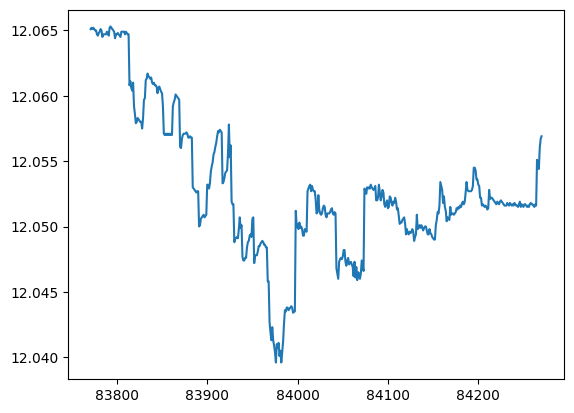

In [18]:
plt.plot(ddf['close'].iloc[-500:])

In [7]:
learning(90212)

Step 90212
Step 90213
Step 90214
Step 90215
Step 90216
Step 90217
Step 90218
Step 90219
Step 90220
Step 90221
Step 90222
Step 90223
Step 90224
Step 90225
Step 90226
Step 90227
Step 90228
Step 90229
Step 90230
Step 90231
Step 90232
Step 90233
Step 90234
Step 90235
Step 90236
Step 90237
Step 90238
Step 90239
Step 90240
Step 90241
Step 90242
Step 90243
Step 90244
Step 90245
Step 90246
Step 90247
Step 90248
Step 90249
Step 90250
Step 90251
Step 90252
Step 90253
Step 90254
Step 90255
Step 90256
Step 90257
Step 90258
Step 90259
Step 90260
Step 90261
Step 90262
Step 90263
Step 90264
Step 90265
Step 90266
Step 90267
Step 90268
Step 90269
Step 90270
Step 90271
Step 90272
Step 90273
Step 90274
Step 90275
Step 90276
Step 90277
Step 90278
Step 90279
Step 90280
Step 90281
Step 90282
Step 90283
Step 90284
Step 90285
Step 90286
Step 90287
Step 90288
Step 90289
Step 90290
Step 90291
Step 90292
Step 90293
Step 90294
Step 90295
Step 90296
Step 90297
Step 90298
Step 90299
Step 90300
Step 90301
Step 90302

KeyboardInterrupt: 